```markdown
# Visualisation
```

In [1]:
#functions
import networkx as nx
import matplotlib.pyplot as plt
import time
import numpy as np
from scipy.spatial.distance import pdist, squareform
from matplotlib.patches import FancyArrowPatch
#from model import generate_data, seq2seq_generate_tour,MambaFull, compute_tour_length
import torch
def compute_tour_length(x, tour,remove_start_token=True,get_tour_only=True,get_cumulative=False): 
    """
    Compute the length of a batch of tours
    Inputs : x of size (bsz, city_count+1, 2) batch of tsp tour instances
             tour of size (bsz, city_count) batch of sequences (node indices) of tsp tours
    Output : L of size (bsz,)             batch of lengths of each tsp tour
    """
    if remove_start_token:
        x = x[:,:-1,:]
    bsz = x.shape[0]
    arange_vec = torch.arange(bsz, device=x.device).unsqueeze(-1)
    tour = tour.to(x.device)

    # Get the cities in the order of the tour
    ordered_cities = x[arange_vec, tour, :] # size(ordered_cities)=(bsz, city_count, 2)

    # Compute the differences between each pair of consecutive cities
    diffs = ordered_cities[:, 1:, :] - ordered_cities[:, :-1, :] # size(diffs)=(bsz, city_count-1, 2)

    # Compute the distance between each pair of consecutive cities
    distances = torch.sqrt(torch.sum(diffs**2, dim=2)) # size(distances)=(bsz, city_count-1)

    # Add the distance from the last city to the first
    distances = torch.cat([distances, torch.norm(ordered_cities[:, 0, :] - ordered_cities[:, -1, :], dim=1).unsqueeze(-1)], dim=1)
    # Sum the distances to get the total length of each tour
    L = torch.sum(distances, dim=1)
    if get_cumulative:
        L = torch.cumsum(distances,dim=1).mean(0)
    if get_tour_only:
        return L
    #this will both return the tour and the length
    else:
        return L, distances

def plot_tsp_old(x_coord, x_path, plot_concorde=False, plot_dist_pair=False):
    """
    Helper function to plot TSP tours.
    """

    # pytorch detach
    x_coord = x_coord.detach().cpu()
    x_path = x_path.detach().cpu()
    
    # compute TSP lengths
    length_tsp = compute_tour_length(x_coord, x_path, remove_start_token=False)

    # preparation  
    x_coord = np.array(x_coord)
    x_path = np.array(x_path)
    nb_nodes = x_coord.shape[1]
    G = nx.from_numpy_array(np.zeros((nb_nodes,nb_nodes)))
    colors = ['g'] + ['b'] * (nb_nodes - 1)  # Green for 0th node, blue for others
    batch_size = x_coord.shape[0]
    max_nb_plots = 3**2 # max number of TSP plots, x^2 for x rows and x cols 
    nb_plots = batch_size if batch_size<max_nb_plots else max_nb_plots 
    nb_rows = nb_cols = int(nb_plots**0.5)
    if plot_concorde: nb_cols *= 2 # double nb of cols if concorde is plotted 
    f = plt.figure(figsize=(10, 5)) if plot_concorde else plt.figure(figsize=(15, 15)) # figure size  
    
    # gap
    running_time = 0
    gap = 0
    L_concorde = []
    
    # loop over TSPs
    for i in range(nb_plots):
        x_coord_i = x_coord[i]
        pos_i = dict(zip(range(len(x_coord_i)), x_coord_i.tolist()))
        if plot_dist_pair: # Compute pairwise distances matrix for better visualization
            dist_pair_i = squareform(pdist(x_coord_i, metric='euclidean')) 
            G = nx.from_numpy_array(dist_pair_i)
        x_path_i = x_path[i] 
        length_tsp_i = length_tsp[i]
        nodes_pair_tsp_i = []
        for r in range(nb_nodes-1): # compute consecutive nodes in the solution
            nodes_pair_tsp_i.append((x_path_i[r], x_path_i[r+1]))
        nodes_pair_tsp_i.append((x_path_i[nb_nodes-1], x_path_i[0]))
        if plot_concorde: # run concorde solver
            start = time.time()
            graph =  pd.DataFrame({'lat' : x_coord_i[:,0]}); graph['lon'] =  x_coord_i[:,1]
            solver = TSPSolver.from_data( graph.lat, graph.lon, norm="GEO" )  
            solution = solver.solve().tour
            running_time += time.time()-start
            nodes_pair_concorde_i = []
            for r in range(nb_nodes-1):
                nodes_pair_concorde_i.append((solution[r], solution[r+1]))
            nodes_pair_concorde_i.append((solution[nb_nodes-1], solution[0]))
            length_concorde = compute_tour_length(torch.tensor(x_coord_i).unsqueeze(0),torch.tensor(solution).long().unsqueeze(0))
            gap += length_tsp_i/length_concorde - 1.0
            L_concorde.append(length_concorde)
        if plot_concorde:
            subf = f.add_subplot(nb_rows,nb_cols,2*i+1)
            nx.draw_networkx_nodes(G, pos_i, node_color=colors, node_size=20)
            nx.draw_networkx_edges(G, pos_i, edgelist=nodes_pair_tsp_i, alpha=1, width=1, edge_color='r')
            if plot_dist_pair:
                nx.draw_networkx_edges(G, pos_i, alpha=0.3, width=0.5)
            subf.set_title('Length w/ NNetwork : ' + str(length_tsp_i.item())[:5])
            subf = f.add_subplot(nb_rows,nb_cols,2*i+2)
            nx.draw_networkx_nodes(G, pos_i, node_color=colors, node_size=20)
            nx.draw_networkx_edges(G, pos_i, edgelist=nodes_pair_concorde_i, alpha=1, width=1, edge_color='b') #, style='dashed'
            if plot_dist_pair:
                nx.draw_networkx_edges(G, pos_i, alpha=0.3, width=0.5)
            subf.set_title('Length w/ Concorde : ' + str(length_concorde.item())[:5])
        else:
            subf = f.add_subplot(nb_rows,nb_cols,i+1)
            nx.draw_networkx_nodes(G, pos_i, node_color=colors, node_size=20)
            nx.draw_networkx_edges(G, pos_i, edgelist=nodes_pair_tsp_i, alpha=1, width=1, edge_color='r')
            if plot_dist_pair:
                nx.draw_networkx_edges(G, pos_i, alpha=0.3, width=0.5)
            subf.set_title('Length w/ NNetwork : ' + str(length_tsp_i.item())[:5])
       

    
    # gap
    if plot_concorde:
        L_concorde = torch.stack(L_concorde).squeeze()
        print('L_concorde',L_concorde)
        print('Concorde time: {:.3f}sec'.format(running_time))  
        print('gap:',(gap/nb_plots).item())


def plot_tsp(x_coord, tours, probability=None, plot_dist_pair=False,save=None):
    """
    Helper function to plot a single TSP problem with four different tours.
    
    Args:
    x_coord (numpy.ndarray): Coordinates of cities, shape (n, 2)
    tours (list): List of 4 tours, each tour is a list/array of city indices
    probability (list, optional): List of 4 lists, each containing probabilities for the edges in the corresponding tour
    plot_dist_pair (bool): Whether to plot pairwise distances
    """
    names=['Mamba','Transformer','Optimal','Greedy']
    tours = [tour.tolist() for tour in tours]
    # Ensure x_coord is numpy array
    x_coord = np.array(x_coord)
    nb_nodes = x_coord.shape[0]
    
    # Create a graph
    G = nx.Graph()
    pos = dict(zip(range(nb_nodes), x_coord.tolist()))
    
    if plot_dist_pair:
        dist_pair = squareform(pdist(x_coord, metric='euclidean'))
        G = nx.from_numpy_array(dist_pair)
    else:
        G.add_nodes_from(range(nb_nodes))  # Ensure nodes are added to the graph
    
    # Create a 1x4 subplot
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs = axs.ravel()
    
    for i, tour in enumerate(tours):
        if i==3:
            break
        # Compute tour length
        length = sum(np.linalg.norm(x_coord[tour[j]] - x_coord[tour[j-1]]) for j in range(nb_nodes))
        
        # Create edge list for the tour
        edges = list(zip(tour, tour[1:] + [tour[0]]))
        
        # Colors for nodes
        colors = ['b'] * nb_nodes  # Default color blue
        colors[tour[0]] = 'g'  # Green for the first node of the tour
        node_sizes = [80 if i == tour[0] else 30 for i in range(nb_nodes)]
        
        # Plot nodes
        nx.draw_networkx_nodes(G, pos, ax=axs[i], node_color=colors, node_size=node_sizes)
        
        # Plot edges with arrows and probabilities if provided
        for j, (u, v) in enumerate(edges):
            axs[i].add_patch(FancyArrowPatch(posA=pos[u], posB=pos[v], arrowstyle='->', color='r', mutation_scale=20))
            if probability is not None and probability[i] is not None:
                prob = probability[i][j]
                mid_point = (np.array(pos[u]) + np.array(pos[v])) / 2
                axs[i].text(mid_point[0], mid_point[1], f'{prob:.2f}', fontsize=10, color='black')
        
        if plot_dist_pair:
            nx.draw_networkx_edges(G, pos, ax=axs[i], alpha=0.08, width=0.5)
        
        axs[i].set_title(f'Tour {names[i]}: Length = {length:.3f}', fontsize=16)
        axs[i].axis('off')
    
    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    plt.show()

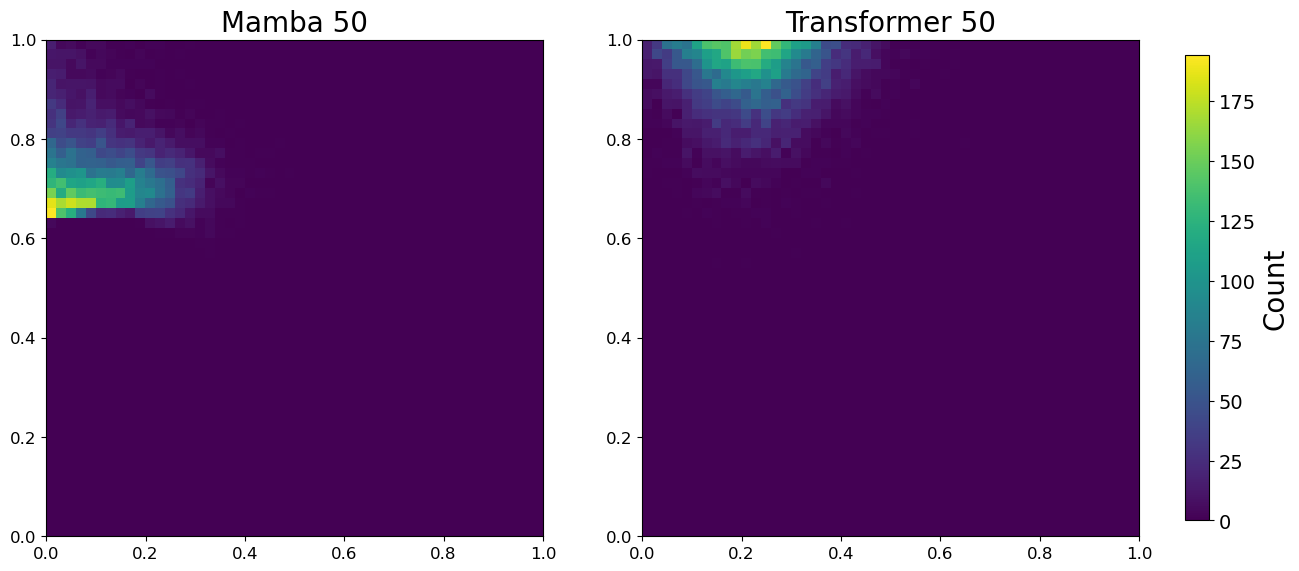

In [4]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from benchmarks.pyconcorde.concorde.tsp import TSPSolver
from benchmarks.benchmark_solvers import greedy_tsp

# Load test data
test_data = []
city_count = [50, 100]
for i in range(2):
    test_data_loc = f'data/transformer_data/10k_TSP{city_count[i]}.pt'
    test_data.append(torch.load(test_data_loc))

# Load tours and probabilities
tours_mamba = torch.load('evals/mamba_v_transformer/tours_mamba.pt', map_location=torch.device('cpu'))
tours_transformer = torch.load('evals/mamba_v_transformer/tours_transformer.pt', map_location=torch.device('cpu'))
probs_mamba = torch.load('evals/mamba_v_transformer/prob_of_action_mamba.pt', map_location=torch.device('cpu'))
probs_transformer = torch.load('evals/mamba_v_transformer/prob_of_action_transformer.pt', map_location=torch.device('cpu'))

# Load test data labels
test_data_labels = []
for k in range(2):
    test_data_label_loc = f'data/transformer_data/10k_TSP{city_count[k]}_len.pt'
    test_data_labels.append(torch.load(test_data_label_loc).to('cpu'))

# Prepare data for heatmaps
x_mamba, y_mamba = [], []
x_transformer, y_transformer = [], []

for i in range(10000):
    x_mamba.append(test_data[0][i][tours_mamba[0][i][0]][0].item())
    y_mamba.append(test_data[0][i][tours_mamba[0][i][0]][1].item())
    x_transformer.append(test_data[0][i][tours_transformer[0][i][0]][0].item())
    y_transformer.append(test_data[0][i][tours_transformer[0][i][0]][1].item())

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Create heatmaps
heatmap_mamba, xedges, yedges = np.histogram2d(x_mamba, y_mamba, bins=50, range=[[0, 1], [0, 1]])
heatmap_transformer, _, _ = np.histogram2d(x_transformer, y_transformer, bins=50, range=[[0, 1], [0, 1]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# Plot heatmaps
im1 = ax1.imshow(heatmap_mamba.T, extent=extent, origin='lower', cmap='viridis')
im2 = ax2.imshow(heatmap_transformer.T, extent=extent, origin='lower', cmap='viridis')

ax1.set_title('Mamba 50', fontsize=20)
ax2.set_title('Transformer 50', fontsize=20)

# Use the same color bar for both subplots
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Count', fontsize=20)
# Set color bar tick parameters
cbar.ax.tick_params(labelsize=14)
# increase font size axis labels
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)


# Increase font size of any text

plt.savefig('evals/figs/analysis/heatmap.pdf', bbox_inches='tight')

plt.show()